## 예제 3-4 붓꽃 데이터에 대한 오토인코더

예제 3-4: Autoencoder를 iris 데이터에 적용

In [1]:
## 필요한 라이브러리를 불러들임 
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
## iris 데이터 불러오기
url='https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv'
iris = pd.read_csv(url)

In [4]:
## iris 데이터를 입력 데이터와 출력 데이터로 분리        
irisX = np.array(iris.iloc[:,:4])
irisY = iris.iloc[:,4]   

In [5]:
## 입력 데이터의 min-max 정규화 
minmax = np.amin(irisX, 0), np.amax(irisX, 0)
no_irisX = (irisX-minmax[0])/(minmax[1]-minmax[0])

In [6]:
## 학습관련 매개변수 설정 
n_input     = 4
n_hidden    = 2  
n_output = n_input
learning_rate = 0.01
n_class = 3
num_epoch = 1000

In [7]:
## 오토인코더 구축 및 계산
X = tf.placeholder(tf.float32, shape=[None, n_input])
hidden = tf.layers.dense(X, n_hidden, activation=None)
output = tf.layers.dense(hidden, n_output, activation=None)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [8]:
reconstruction_loss = tf.reduce_mean(tf.square(output - X))
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

In [9]:
codings = hidden

In [10]:
## 텐서플로 그래프 실행
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # 학습 시작  
    for iteration in range(num_epoch):
        training_op.run(feed_dict={X: no_irisX})
    
    codings_val = codings.eval(feed_dict={X: no_irisX})

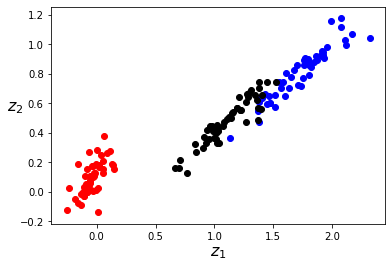

In [11]:
## 오토인코더 은닉노드의 값 산점도
plt.scatter(codings_val[np.where(irisY=='setosa')[0], 0], codings_val[np.where(irisY=='setosa')[0], 1], color = 'red')
plt.scatter(codings_val[np.where(irisY=='virginica')[0], 0], codings_val[np.where(irisY=='virginica')[0], 1], color = 'blue')
plt.scatter(codings_val[np.where(irisY=='versicolor')[0], 0], codings_val[np.where(irisY=='versicolor')[0], 1], color = 'black')
plt.xlabel("$z_1$", fontsize=16)
plt.ylabel("$z_2$", fontsize=16, rotation=0)
plt.show()

## 예제 3-5 MNIST 데이터에 대한 희박 오토인코더

예제 3-5: 희박 오토인코더: Pro Deep Learning + Hands on ML

In [5]:
## 필요한 라이브러리를 불러들임 
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [27]:
tf.disable_v2_behavior()

In [6]:
# MNIST 데이터 읽어들임
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [9]:
# 학습관련 매개변수 설정
learning_rate = 0.001
wgt_decay = 0.0001
sparse_penalty = 0.001
batch_size = 1000
display_step = 1
examples_to_show = 10

In [10]:
n_input = 28*28 # MNIST 데이터 입력 
n_hidden = 32*32 # 은닉노드 개수

In [11]:
# 입력, 가중치 및 편향을 정의함
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h': tf.Variable(tf.random_normal([n_input,n_hidden])), # 784 * 1024
    'decoder_h': tf.Variable(tf.random_normal([n_hidden,n_input])), # 1024 * 784
}    
biases = {
    'encoder_b': tf.Variable(tf.random_normal([n_hidden])), # 1024 * 1
    'decoder_b': tf.Variable(tf.random_normal([n_input])),  # 784 * 1
}

In [12]:
# 인코더를 구축함
def encoder(x):
    # sigmoid(X(M, 784) .* W1(784, 1024) + b1(1024, 1)) = a1(M, 1024)
    e_layer = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h']),
                                   biases['encoder_b']))
    return e_layer

In [13]:
# 디코더를 구축함
def decoder(x):
    # sigmoid(a1(M, 1024) .* W1'(1024 * 784) + b2(784, 1)) = a2(M, 784)
    d_layer = tf.nn.sigmoid(tf.add(tf.matmul(x, tf.transpose(weights['encoder_h'])),
                                   biases['decoder_b']))
    return d_layer

In [14]:
# Kullback Leibler 정보량 계산
def kl_div(rho, rho_hat):
    # Kullback Leibler divergence
    return rho * tf.log(rho / rho_hat) + (1 - rho) * tf.log((1 - rho) / (1 - rho_hat))

In [21]:
# 오토인코더 모형 구축
op_encoder = encoder(X)
print(op_encoder.shape)
op_decoder = decoder(op_encoder)
print(op_decoder.shape)
rho_hat = tf.reduce_mean(op_encoder,1) # 인코더층의 출력값을 column 기준으로 평균을 낸다. 즉, 모든 input X에 대한 인코더층의 출력값을 노드별로 평균낸다.
print(rho_hat.shape)

(?, 1024)
(?, 784)
(?,)


In [16]:
# 예측값
y_true = X
y_pred = op_decoder

In [22]:
# 손실함수 및 최적화 정의 
loss_mse = tf.reduce_mean(tf.square(y_true - y_pred))
loss_reg = wgt_decay*tf.nn.l2_loss(weights['encoder_h']) # wgt_decay(0.0001) * 인코더층의 가중치행렬에 대한 L2 regularization
loss_sparse = sparse_penalty*tf.reduce_sum(kl_div(0.2,rho_hat)) # sparse_penalty(0.001) * KL정보량(Kullback_Leibler divergence)
loss = loss_mse + loss_reg + loss_sparse # 최종 손실함수

In [23]:
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch: 0001 loss = 40.696487427
Epoch: 0002 loss = 40.648864746
Epoch: 0003 loss = 39.889976501
Epoch: 0004 loss = 36.969833374
Epoch: 0005 loss = 33.782772064
Epoch: 0006 loss = 30.814819336
Epoch: 0007 loss = 28.058656693
Epoch: 0008 loss = 25.500284195
Epoch: 0009 loss = 23.135513306
Epoch: 0010 loss = 20.953334808
Epoch: 0011 loss = 18.942319870
Epoch: 0012 loss = 17.093387604
Epoch: 0013 loss = 15.395942688
Epoch: 0014 loss = 13.841073990
Epoch: 0015 loss = 12.421439171
Epoch: 0016 loss = 11.126357079
Epoch: 0017 loss = 9.946323395
Epoch: 0018 loss = 8.873196602
Epoch: 0019 loss = 7.900848866
Epoch: 0020 loss = 7.020365715
Epoch: 0021 loss = 6.226189613
Epoch: 0022 loss = 5.511125565
Epoch: 0023 loss = 4.868218422
Epoch: 0024 loss = 4.291055679
Epoch: 0025 loss = 3.774963617
Epoch: 0026 loss = 3.313818693
Epoch: 0027 loss = 2.903254032
Epoch: 0028 loss = 2.538367033
Epoch: 0029 loss = 2.214936972
Epoch: 0030 loss = 1.928791165
Epoch: 0031 loss = 1.676360488
Epoch: 0032 loss = 1.45

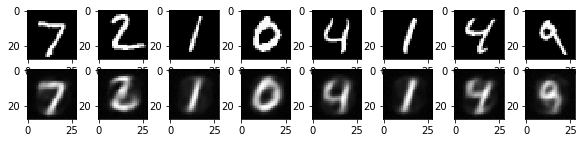

In [24]:
# 텐서플로 그래프 실행
start_time = time.time()
with tf.Session() as sess:
	# 모형의 변수들을 초기화하기
    init = tf.global_variables_initializer()
    sess.run(init)
    num_batch = int(mnist.train.num_examples/batch_size)
    # 학습 과정
    num_epoch = 100
    for epoch in range(num_epoch):
        # 모든 미니배치에 대해 반복함
        for i in range(num_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, los = sess.run([optimizer, loss], feed_dict={X: batch_xs})
        # 실행 단계 보여주기
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "loss =", "{:.9f}".format(los))

    print("Optimization Finished!")

    # 검정 데이터 집합에 인코더와 디코더를 적용함
    n_digit = 8
    reconstruct_digit = sess.run(y_pred, feed_dict={X: mnist.test.images[:n_digit]})
    # 검정 데이터에 속하는 원래 이미지와 복원된 이미지를 비교함 
    fig, a = plt.subplots(2, n_digit, figsize=(10, 2))
    for i in range(n_digit):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)),cmap='gray')
        a[1][i].imshow(np.reshape(reconstruct_digit[i], (28, 28)),cmap='gray')
    # 인코더 및 디코더 관련 가중치를 저장함 
    w_encod = sess.run(weights['encoder_h'])
    w_decod = sess.run(weights['decoder_h'])
end_time = time.time()
print('elapsed time:',end_time - start_time)

## 예제 3-5 MNIST 데이터에 대한 희박 오토인코더 (수정)

In [1]:
## 필요한 라이브러리를 불러들임 
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# MNIST 데이터 읽어들임
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [4]:
# 학습관련 매개변수 설정
learning_rate = 0.001
wgt_decay = 0.0001
sparse_penalty = 0.001
batch_size = 1000
display_step = 1
examples_to_show = 10

In [5]:
n_input = 28*28 # MNIST 데이터 입력 
n_hidden = 32*32 # 은닉노드 개수

In [6]:
# 입력, 가중치 및 편향을 정의함
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h': tf.Variable(tf.random_normal([n_input,n_hidden])), # 784 * 1024
    'decoder_h': tf.Variable(tf.random_normal([n_hidden,n_input])), # 1024 * 784
}    
biases = {
    'encoder_b': tf.Variable(tf.random_normal([n_hidden])), # 1024 * 1
    'decoder_b': tf.Variable(tf.random_normal([n_input])),  # 784 * 1
}

In [7]:
# 인코더를 구축함
def encoder(x):
    # sigmoid(X(M, 784) .* W1(784, 1024) + b1(1024, 1)) = a1(M, 1024)
    e_layer = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h']),
                                   biases['encoder_b']))
    return e_layer

In [8]:
# 수정됨
# 디코더를 구축함
def decoder(x):
    # sigmoid(a1(M, 1024) .* W2(1024 * 784) + b2(784, 1)) = a2(M, 784)
    # (기존) d_layer = tf.nn.sigmoid(tf.add(tf.matmul(x, tf.transpose(weights['encoder_h'])), biases['decoder_b']))
    d_layer = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h']), biases['decoder_b']))
    return d_layer

In [9]:
# Kullback Leibler 정보량 계산
def kl_div(rho, rho_hat):
    # Kullback Leibler divergence
    return rho * tf.log(rho / rho_hat) + (1 - rho) * tf.log((1 - rho) / (1 - rho_hat))

In [10]:
# 수정됨
# 오토인코더 모형 구축
op_encoder = encoder(X)
print(op_encoder.shape)
op_decoder = decoder(op_encoder)
print(op_decoder.shape)
# (기존) rho_hat = tf.reduce_mean(op_encoder,1) # 인코더층의 출력값을 column 기준으로 평균을 낸다. 즉, 모든 input X에 대한 인코더층의 출력값을 노드별로 평균낸다.
rho_hat = tf.reduce_mean(op_encoder,0) 
print(rho_hat.shape)

(?, 1024)
(?, 784)
(1024,)


In [11]:
# 예측값
y_true = X
y_pred = op_decoder

In [12]:
# 손실함수 및 최적화 정의 
loss_mse = tf.reduce_mean(tf.square(y_true - y_pred))
loss_reg = wgt_decay*tf.nn.l2_loss(weights['encoder_h']) # wgt_decay(0.0001) * 인코더층의 가중치행렬에 대한 L2 regularization
loss_sparse = sparse_penalty*tf.reduce_sum(kl_div(0.2,rho_hat)) # sparse_penalty(0.001) * KL정보량(Kullback_Leibler divergence)
loss = loss_mse + loss_reg + loss_sparse # 최종 손실함수

In [13]:
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch: 0001 loss = 40.984786987
Epoch: 0002 loss = 40.936012268
Epoch: 0003 loss = 40.158676147
Epoch: 0004 loss = 37.115447998
Epoch: 0005 loss = 33.814266205
Epoch: 0006 loss = 30.808605194
Epoch: 0007 loss = 28.042312622
Epoch: 0008 loss = 25.486625671
Epoch: 0009 loss = 23.125164032
Epoch: 0010 loss = 20.945426941
Epoch: 0011 loss = 18.939346313
Epoch: 0012 loss = 17.095376968
Epoch: 0013 loss = 15.403028488
Epoch: 0014 loss = 13.853285789
Epoch: 0015 loss = 12.437021255
Epoch: 0016 loss = 11.146495819
Epoch: 0017 loss = 9.970377922
Epoch: 0018 loss = 8.902605057
Epoch: 0019 loss = 7.933977127
Epoch: 0020 loss = 7.056795597
Epoch: 0021 loss = 6.264178753
Epoch: 0022 loss = 5.553023815
Epoch: 0023 loss = 4.912185669
Epoch: 0024 loss = 4.335026264
Epoch: 0025 loss = 3.819047689
Epoch: 0026 loss = 3.360224247
Epoch: 0027 loss = 2.948048353
Epoch: 0028 loss = 2.584152937
Epoch: 0029 loss = 2.258210659
Epoch: 0030 loss = 1.971520305
Epoch: 0031 loss = 1.717060566
Epoch: 0032 loss = 1.49

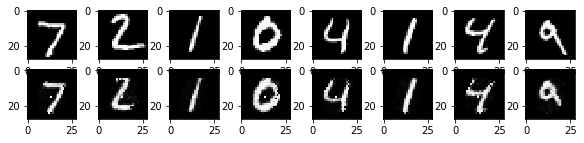

In [14]:
# 텐서플로 그래프 실행
start_time = time.time()
sess = tf.Session()
# 모형의 변수들을 초기화하기
init = tf.global_variables_initializer()
sess.run(init)
num_batch = int(mnist.train.num_examples/batch_size)
# 학습 과정
num_epoch = 100
for epoch in range(num_epoch):
    # 모든 미니배치에 대해 반복함
    for i in range(num_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, los = sess.run([optimizer, loss], feed_dict={X: batch_xs})
    # 실행 단계 보여주기
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "loss =", "{:.9f}".format(los))

print("Optimization Finished!")

# 검정 데이터 집합에 인코더와 디코더를 적용함
n_digit = 8
reconstruct_digit = sess.run(y_pred, feed_dict={X: mnist.test.images[:n_digit]})
# 검정 데이터에 속하는 원래 이미지와 복원된 이미지를 비교함 
fig, a = plt.subplots(2, n_digit, figsize=(10, 2))
for i in range(n_digit):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)),cmap='gray')
    a[1][i].imshow(np.reshape(reconstruct_digit[i], (28, 28)),cmap='gray')
# 인코더 및 디코더 관련 가중치를 저장함 
w_encod = sess.run(weights['encoder_h'])
w_decod = sess.run(weights['decoder_h'])

end_time = time.time()
print('elapsed time:',end_time - start_time)

In [15]:
encoder_digit = sess.run(op_encoder, feed_dict={X: mnist.test.images})

In [16]:
encoder_digit.shape

(10000, 1024)

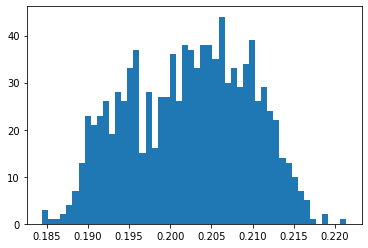

In [17]:
# encoder 층 출력값의 평균의 분포
_ = plt.hist(np.mean(encoder_digit, 0), bins=50)

## 예제 3-6 MNIST 데이터에 잡음 제거 오토인코더 (수정)

예제 3-6: 잡음 제거 오토인코더: Pro Deep Learning + Hands on ML

In [6]:
## 필요한 라이브러리를 불러들임 
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [7]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [56]:
# 학습관련 매개변수 설정
learning_rate = 0.01
batch_size = 150
display_step = 1
examples_to_show = 10
noise_level = 1

In [46]:
# MNIST 데이터 읽어들임
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [47]:
n_input = 28*28 # MNIST 데이터 입력 
n_hidden = 300 # 은닉노드 개수

In [48]:
# 잡음 포함 입력, 가중치 및 편향을 정의함
X = tf.placeholder("float", [None, n_input])
# (기존) X_noisy = X + noise_level * tf.random_normal(tf.shape(X))
X_noisy = tf.placeholder("float", [None, n_input])

In [49]:
weights = {
    'encoder_h': tf.Variable(tf.random_normal([n_input,n_hidden])),
    'decoder_h': tf.Variable(tf.random_normal([n_hidden,n_input])),
}    
biases = {
    'encoder_b': tf.Variable(tf.random_normal([n_hidden])),
    'decoder_b': tf.Variable(tf.random_normal([n_input])),
}

In [50]:
# 인코더를 구축함
def encoder(x):
    e_layer = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h']),
                                   biases['encoder_b']))
    return e_layer

In [51]:
# 수정됨
# 디코더를 구축함
def decoder(x):
    # (기존) d_layer = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h']), biases['decoder_b']))
    d_layer = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h']), biases['decoder_b']))
    return d_layer

In [52]:
# 오토인코더 모형 구축
op_encoder = encoder(X_noisy)
op_decoder = decoder(op_encoder)

In [53]:
# 예측값
y_true = X
y_pred = op_decoder

In [54]:
# 손실함수 및 최적화 정의 
loss = tf.reduce_mean(tf.square(y_true - y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Epoch: 0001 loss = 0.056028821
Epoch: 0002 loss = 0.049108617
Epoch: 0003 loss = 0.042899668
Epoch: 0004 loss = 0.040384732
Epoch: 0005 loss = 0.040472861
Epoch: 0006 loss = 0.037346762
Epoch: 0007 loss = 0.034294993
Epoch: 0008 loss = 0.035867751
Epoch: 0009 loss = 0.033924930
Epoch: 0010 loss = 0.036983203
Optimization Finished!
elapsed time: 19.7629554271698


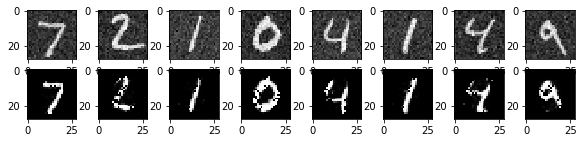

In [58]:
# 텐서플로 그래프 실행
start_time = time.time()
with tf.Session() as sess:
	# 모형의 변수들을 초기화하기
    init = tf.global_variables_initializer()
    sess.run(init)
    num_batch = int(mnist.train.num_examples/batch_size)
    # 학습 과정
    num_epoch = 10
    for epoch in range(num_epoch):
        # 모든 미니배치에 대해 반복함
        for i in range(num_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            batch_xs_noisy = batch_xs + noise_level * np.random.normal(size=batch_xs.shape) # noise가 포함된 input 데이터 생성
            batch_xs_noisy = batch_xs_noisy.astype(np.float32)
            _, los = sess.run([optimizer, loss], feed_dict={X_noisy: batch_xs_noisy, X: batch_xs})
        # 실행 단계 보여주기
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "loss =", "{:.9f}".format(los))

    print("Optimization Finished!")

    # 검정 데이터 집합에 인코더와 디코더를 적용함
    n_digit = 8
    xs = mnist.test.images[:n_digit]
    xs_noisy = xs + noise_level * np.random.normal(size=xs.shape) # noise가 포함된 input 데이터 생성
    xs_noisy = xs_noisy.astype(np.float32)
    reconstruct_digit = sess.run(y_pred, feed_dict={X_noisy: xs_noisy, X: xs})
    # 검정 데이터에 속하는 원래 이미지와 복원된 이미지를 비교함 
    fig, a = plt.subplots(2, n_digit, figsize=(10, 2))
    for i in range(n_digit):
        a[0][i].imshow(np.reshape(xs_noisy[i], (28, 28)),cmap='gray')
        a[1][i].imshow(np.reshape(reconstruct_digit[i], (28, 28)),cmap='gray')
    # 인코더 및 디코더 관련 가중치를 저장함 
    w_encod = sess.run(weights['encoder_h'])
    w_decod = sess.run(weights['decoder_h'])
end_time = time.time()
print('elapsed time:',end_time - start_time)

## 예제 3-7 MNIST 데이터에 대한 분류용 - DBN

In [60]:
# 필요한 라이브러리를 불러들임 
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
%matplotlib inline

tf.disable_v2_behavior()

# MNIST 파일 읽어들임
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

# 학습관련 매개변수 설정
n_input      = 784
n_hidden1    = 500
n_hidden2    = 256
display_step = 1
n_epoch = 200 
batch_size = 256 
lr_rbm = tf.constant(0.001, tf.float32)
lr_class = tf.constant(0.01, tf.float32)
n_class = 10
n_iter = 200

# 입력 및 출력을 정의함
x  = tf.placeholder(tf.float32, [None, n_input], name="x") 
y  = tf.placeholder(tf.float32, [None,10], name="y") 

# 첫 번째 은닉층 관련 가중치 및 편향을 정의함
W1  = tf.Variable(tf.random_normal([n_input, n_hidden1], 0.01), name="W1") 
b1_h = tf.Variable(tf.zeros([1, n_hidden1],  tf.float32, name="b1_h")) 
b1_i = tf.Variable(tf.zeros([1, n_input],  tf.float32, name="b1_i")) 

# 두 번째 은닉층 관련 가중치 및 편향을 정의함
W2  = tf.Variable(tf.random_normal([n_hidden1, n_hidden2], 0.01), name="W2") 
b2_h = tf.Variable(tf.zeros([1, n_hidden2],  tf.float32, name="b2_h")) 
b2_i = tf.Variable(tf.zeros([1, n_hidden1],  tf.float32, name="b2_i")) 

# 라벨층 관련 가중치 및 편향을 정의함
W_c = tf.Variable(tf.random_normal([n_hidden2,n_class], 0.01), name="W_c") 
b_c = tf.Variable(tf.zeros([1, n_class],  tf.float32, name="b_c")) 

# 확률을 이산 상태, 즉 0과 1로 변환함 
def binary(prob):
    return tf.floor(prob + tf.random_uniform(tf.shape(prob), 0, 1))

# Gibbs 표본추출 단계
def cd_step(x_k,W,b_h,b_i):
    h_k = binary(tf.sigmoid(tf.matmul(x_k, W) + b_h)) 
    x_k = binary(tf.sigmoid(tf.matmul(h_k, tf.transpose(W)) + b_i))
    return x_k

# 표본추출 단계 실행     
def cd_gibbs(k,x_k,W,b_h,b_i):
    for i in range(k):
        x_out = cd_step(x_k,W,b_h,b_i) 
    # k 반복 후에 깁스 표본을 반환함
    return x_out

# 2개의 은닉층을 갖는 DBN에 대한 CD-2 알고리즘
# 1. 현재 입력값을 기반으로 깁스 표본추출을 통해 새로운 입력값 x_s를 구함
# 2. 새로운 x_s를 기반으로 새로운 은닉노드 값 h_s를 구함    
x_s = cd_gibbs(2,x,W1,b1_h,b1_i) 
act_h1_s = binary(tf.sigmoid(tf.matmul(x_s, W1) + b1_h)) 
h1_s = cd_gibbs(2,act_h1_s,W2,b2_h,b2_i) 
act_h2_s = binary(tf.sigmoid(tf.matmul(h1_s, W2) + b2_h)) 

# 입력값이 주어질 때 은닉노드 값 h를 구함
act_h1 = tf.sigmoid(tf.matmul(x, W1) + b1_h) 
act_h2 = tf.sigmoid(tf.matmul(act_h1_s, W2) + b2_h) 

# 경사 하강법을 이용한 가중치 및 편향 업데이트 
size_batch = tf.cast(tf.shape(x)[0], tf.float32)

W1_add  = tf.multiply(lr_rbm/size_batch, tf.subtract(tf.matmul(tf.transpose(x), \
          act_h1), tf.matmul(tf.transpose(x_s), act_h1_s)))
b1_i_add = tf.multiply(lr_rbm/size_batch, tf.reduce_sum(tf.subtract(x, x_s), \
           0, True))
b1_h_add = tf.multiply(lr_rbm/size_batch, tf.reduce_sum(tf.subtract(act_h1, act_h1_s), \
           0, True))

W2_add  = tf.multiply(lr_rbm/size_batch, tf.subtract(tf.matmul(tf.transpose(act_h1_s), \
          act_h2), tf.matmul(tf.transpose(h1_s), act_h2_s)))
b2_i_add = tf.multiply(lr_rbm/size_batch, tf.reduce_sum(tf.subtract(act_h1_s, h1_s), \
           0, True))
b2_h_add = tf.multiply(lr_rbm/size_batch, tf.reduce_sum(tf.subtract(act_h2, act_h2_s), \
        0, True))

updt = [W1.assign_add(W1_add), b1_i.assign_add(b1_i_add), b1_h.assign_add(b1_h_add),\
        W2.assign_add(W2_add), b2_i.assign_add(b2_i_add), b2_h.assign_add(b2_h_add)]

#-------------------------------------------------------------
# 소프트맥스 층을 추가한 분류용-DBN 을 위한 연산과정
#------------------------------------------------------------- 

logits = tf.matmul(act_h2,W_c) + b_c
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=lr_class).minimize(cost)
correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

#-------------------------------------------------------------                   
# RBM을 쌓아 올려가며 DBN을 학습하는 텐서플로 그래프 실행   
#-------------------------------------------------------------
with tf.Session() as sess:
    # Initialize the variables of the Model
    init = tf.global_variables_initializer()
    sess.run(init)
    
    n_batch = int(mnist.train.num_examples/batch_size)
    # Start the training 
    for epoch in range(n_epoch):
        # Loop over all batches
        for i in range(n_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run the weight update 
            batch_xs = (batch_xs > 0)*1
            _ = sess.run([updt], feed_dict={x:batch_xs})
            
        # Display the running step 
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1))
                  
    print("RBM training Completed !")
 
#--------------------------------------------------------------
# 소프트맥스 층을 추가한 분류용-DBN 학습 및 예측
#--------------------------------------------------------------
    for i in range(n_iter):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # 최적화 과정 실행
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if i % 10 == 0:
            # MINIST 훈련용 이미지의 배치에 대한 손실과 정확도를 계산
            tr_loss, tr_acc = sess.run([cost, accuracy], 
            	                    feed_dict={x: batch_x, y: batch_y})
            print("Iter " + str(i) + ", Minibatch Loss= " + \
                  "{:.6f}".format(tr_loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(tr_acc))
        
    print("Optimization Finished!")

    # MINIST 검정용 이미지에 대한 정확도 계산 
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: mnist.test.images,
                                      y: mnist.test.labels}))

    sess.close()
    # Testing Accuracy: 0.8769

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Epoch: 0001
Epoch: 0002
Epoch: 0003
Epoch: 0004
Epoch: 0005
Epoch: 0006
Epoch: 0007
Epoch: 0008
Epoch: 0009
Epoch: 0010
Epoch: 0011
Epoch: 0012
Epoch: 0013
Epoch: 0014
Epoch: 0015
Epoch: 0016
Epoch: 0017
Epoch: 0018
Epoch: 0019
Epoch: 0020
Epoch: 0021
Epoch: 0022
Epoch: 0023
Epoch: 0024
Epoch: 0025
Epoch: 0026
Epoch: 0027
Epoch: 0028
Epoch: 0029
Epoch: 0030
Epoch: 0031
Epoch: 0032
Epoch: 0033
Epoch: 0034
Epoch: 0035
Epoch: 0036
Epoch: 0037
Epoch: 0038
Epoch: 0039
Epoch: 0040
Epoch: 0041
Epoch: 0042
Epoch: 0043
Epoch: 0044
Epoch: 0045
Epoch: 0046
Epoch: 0047
Epoch: 0048
Epoch: 0049
Epoch: 0050
Epoch: 0051
Epoch: 0052
Epoch: 0053
Epoch: 0054
Epoch: 0055
Epoch: 0056
Epoch: 0057
Epoch: 0058
Epoch: 0059
Epoch: 0060
Epoch: 0061
Epoch: 0062
Epoch: 0063
Epoch: 0064
Epoch: 0065
Epoch: 0066
Epoch: 0067
Ep